In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import math
from pathlib import Path
from skimage.util import img_as_float
from skimage import data, color, morphology, img_as_float
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.model_selection import train_test_split as tts
import imageio
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn import datasets, svm, pipeline

## Data Processing
### Data is ingested and made suitable for a CNN

In [2]:
IMAGE_DIRECTORY_1 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_1"
IMAGE_DIRECTORY_2 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_2"
trimmed_data = pd.read_csv("trimmed_dataset.csv",index_col=0)
trimmed_data.head()

,lesion_id,image_id,dx
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [3]:
trimmed_data.sort_values(by="lesion_id",axis=0,inplace=True)
trimmed_data["dx"]=trimmed_data["dx"].map({"bkl":0,"akiec":1,"bcc":2,
                                           "df":3,"mel":4,"nv":5,"vasc":6})

trimmed_data.drop("lesion_id",axis=1,inplace=True)
trimmed_data.set_index("image_id",inplace=True)
trimmed_data.head()

,dx
image_id,
ISIC_0028498,5
ISIC_0025346,5
ISIC_0027859,0
ISIC_0032622,4
ISIC_0033848,4


In [4]:
row_keys = trimmed_data.columns.values
row_keys

array(['dx'], dtype=object)

## Image collection and transformation
### Resize to uniform 200x200x3

In [6]:
j=0
images = []
image_ids = []
IMG_SIZE= 200
min_w, min_h = math.inf, math.inf 
dim = (IMG_SIZE,IMG_SIZE)
dirs = [IMAGE_DIRECTORY_1,IMAGE_DIRECTORY_2]
for directory in dirs:
    j=0
    for image_name in os.listdir(directory):
        
        filepath = os.path.join(directory,image_name)
        j+=1

        if j>500:
            break
        new_image = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        new_image = img_as_float(new_image)
        resized_image = cv2.resize(new_image,dim)
        
        images.append(resized_image)
        image_ids.append(image_name[:-4])

In [48]:
### OR use segmented area

In [8]:
images = []
image_ids = []
IMG_SIZE= 200
dim=(IMG_SIZE,IMG_SIZE)
j=0
seg_path = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_segmentations_lesion_tschandl"
for seg in os.listdir(seg_path):
    if seg.endswith("png"):
        # if j>500:
        #     break
        seg_im_path = os.path.join(seg_path,seg)
        new_image = cv2.imread(seg_im_path,cv2.IMREAD_GRAYSCALE)
        new_image = img_as_float(new_image)
        resized_image = cv2.resize(new_image,dim)
        images.append(resized_image)
        image_ids.append(seg[:12])
        j+=1

In [10]:
X = images
y = [val[0] for val in trimmed_data.reindex(image_ids).values]

X = np.array(X)#.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_train, X_test, y_train, y_test = tts(X,y,test_size=0.2)

In [13]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [14]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(12,12), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
# X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train)
X_train_prepared = scalify.fit_transform(X_train_hog)
X_test_hog = hogify.fit_transform(X_test)
X_test_prepared = scalify.fit_transform(X_test_hog)
print(X_train_prepared.shape)

(8012, 8100)


In [16]:
kernel_svm = svm.SVC()
linear_svm = svm.LinearSVC()

In [17]:
parameters = {"kernel": ("linear","rbf"),
              "C":[1,5,10],
              "gamma":[1,0.1,0.01,0.001]}

In [18]:
clf = GridSearchCV(kernel_svm, parameters,verbose=1)

In [19]:
clf.fit(X_train_prepared,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

In [44]:
iris_data = datasets.load_wine()
iris_features = iris_data.data
iris_target = iris_data.target

In [45]:
iris_X_train, iris_X_test, iris_y_train, iris_y_test = tts(iris_features, iris_target, test_size=0.25)

In [46]:
clf.fit(iris_X_train,iris_y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 10], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ('linear', 'rbf')},
             verbose=1)

In [47]:
clf.cv_results_

{'mean_fit_time': array([0.04613667, 0.00134335, 0.0458427 , 0.00130401, 0.04549656,
        0.00103602, 0.04578581, 0.00082407, 0.04553614, 0.00124135,
        0.04576483, 0.00134764, 0.04562898, 0.00102878, 0.04542823,
        0.00082669, 0.04603229, 0.00124912, 0.04559131, 0.00133896,
        0.04526148, 0.00103235, 0.04729152, 0.00083089]),
 'std_fit_time': array([2.28662206e-02, 2.54322948e-04, 2.27263586e-02, 4.02280175e-04,
        2.29351672e-02, 1.19386541e-05, 2.31458728e-02, 2.52708516e-04,
        1.25390371e-02, 2.58503253e-04, 1.23596733e-02, 2.63186752e-04,
        1.25530653e-02, 4.05732105e-06, 1.24885926e-02, 2.40458422e-04,
        1.32508729e-02, 2.61561651e-04, 1.22737843e-02, 2.48409186e-04,
        1.23213488e-02, 4.88845306e-06, 1.35357304e-02, 2.58898383e-04]),
 'mean_score_time': array([0.00020428, 0.00052471, 0.00039911, 0.00020003, 0.00010409,
        0.        , 0.00021195, 0.00021381, 0.00030985, 0.00031104,
        0.00020938, 0.00030813, 0.00020614, 0.00

(8100,)


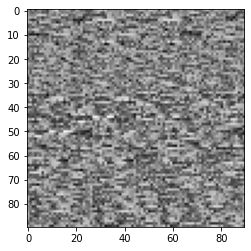

In [39]:
print(X_train_prepared[0].shape)
a = X_train_prepared[0].copy().reshape(90,90)
plt.imshow(a,cmap="gray")

In [27]:
feature_map_fourier = RBFSampler(gamma=.2,random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1)

In [31]:
X_train_prepared.shape

(8012, 8100)

In [ ]:
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC())])

# fit and predict using linear and kernel svm:
kernel_svm.fit(X_train_prepared, y_train)
kernel_svm_score = kernel_svm.score(X_test_prepared, y_test)

linear_svm.fit(X_train_prepared, y_train)
linear_svm_score = linear_svm.score(X_test_prepared, y_test)

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    print(D)
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    
    nystroem_approx_svm.fit(X_train_prepared, y_train)
    fourier_approx_svm.fit(X_train_prepared, y_train)

    fourier_score = fourier_approx_svm.score(X_test_prepared, y_test)
    nystroem_score = nystroem_approx_svm.score(X_test_prepared, y_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

# plot the results:
f = plt.figure(figsize=(16,8))
accuracy = plt.subplot(121)
accuracy2 = plt.subplot(122)
accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel",c="black")
accuracy2.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel",c="green")
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm",c="red")
accuracy2.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm",c="blue")

# legends and labels
accuracy.set_title("Classification accuracy")
accuracy.set_ylabel("Classification accuracy")
accuracy.legend(loc='best')

In [22]:
X_train = X_train.reshape(8012,-1)
X_train.shape

(8012, 40000)

In [23]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3,verbose=1,n_jobs=-1)
sgd_clf.fit(X_train_prepared, y_train)

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 1793.33, NNZs: 8100, Bias: -6354.743748, T: 8012, Avg. loss: 1834.067062
Total training time: 0.19 seconds.
Norm: 2240.90, NNZs: 8100, Bias: -5466.526966, T: 8012, Avg. loss: 2384.020158
Total training time: 0.19 seconds.
-- Epoch 2
-- Epoch 2
Norm: 1639.73, NNZs: 8100, Bias: -6618.294587, T: 8012, Avg. loss: 1753.913658
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 1918.84, NNZs: 8100, Bias: -6275.959309, T: 8012, Avg. loss: 1983.951167
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 1591.10, NNZs: 8100, Bias: -6508.837570, T: 8012, Avg. loss: 1678.253855
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 2199.20, NNZs: 8100, Bias: -5629.076150, T: 8012, Avg. loss: 2261.369260
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 2604.43, NNZs: 8100, Bias: 2618.256674, T: 8012, Avg. loss: 2526.098003
Total training time: 0.23 seconds.
-- Epoch 2
Norm: 1331.57, NNZs: 8100, Bias: -6217.491718, T: 16024, Avg. loss: 151.335747
Total training time: 0.38 seconds.
-- Epoch 3
N

[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  1.3min finished
C:\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(n_jobs=-1, random_state=42, verbose=1)

In [24]:
X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)

In [25]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True  True  True  True  True  True False False  True  True
  True False  True  True False False False  True  True False False  True
  True]

Percentage correct:  64.45332001997005
